In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def lift(y_true, y_pred, lift_perc):
    cutoff=np.percentile(y_pred, lift_perc)       
    return y_true[y_pred<=cutoff].mean()/y_true.mean()

In [ ]:
data = pd.read_csv('sample_data/train.csv') 

In [ ]:
test = pd.read_csv('sample_data/test_.csv') 
test.head()

,Unnamed: 0,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40
0,16380,30.0,1690.0,0.0,1.0,0.500000,1.000000,0.0,2.0,0.000000,2.0,2.0,0.0,0.333333,0.0,0.0,0.0,2.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,3.0,1900.0,0.000000,0.000000,194.800000,404.800000,0.0,2.0,2.0,179.0,179.0,122.0
1,145630,30.0,2710.0,0.0,1.0,289.666667,316.666667,388.0,543.0,218.450000,389.0,1.0,0.0,198.333333,0.0,0.0,145.0,49.0,0.0,139.666667,165.0,254.0,80.200000,0.033333,47.0,89.000000,118.0,566.0,0.0,3.0,10.0,2910.0,126.666667,233.333335,1.066618,14.483347,20.0,4.0,6.0,254.0,NaN,323.0
2,112658,30.0,1690.0,0.0,1.0,189.333333,140.666667,173.0,192.0,268.866667,173.0,0.0,0.0,52.000000,0.0,8.0,111.0,0.0,0.0,161.000000,212.0,273.0,316.233333,0.000000,90.0,81.333333,122.0,768.0,8.0,1.0,2.0,1730.0,3.333333,0.000000,120.279593,18.712925,28.0,3.0,3.0,127.0,NaN,763.0
3,102310,30.0,1603.0,0.0,1.0,213.500000,212.000000,281.0,543.0,399.866667,281.0,1.0,0.0,86.000000,0.0,0.0,185.0,1.0,0.0,247.000000,291.0,497.0,459.100000,0.000000,102.0,115.000000,189.0,2162.0,6.0,2.0,4.0,2850.0,65.833333,66.666667,-281.033344,-380.133364,17.0,5.0,6.0,233.0,NaN,701.0
4,158200,0.0,0.0,0.0,200.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.0


In [ ]:
df = data.drop('Unnamed: 0',axis=1)
df

,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,Label
0,30.0,1590.0,0.0,1.0,195.666667,179.666667,107.0,305.0,158.333333,115.0,5.0,0.0,95.333333,0.0,0.0,19.0,19.0,0.0,120.333333,76.0,188.0,174.816667,0.033333,70.0,43.666667,6.0,436.0,9.0,1.0,2.0,1700.0,2.500000,0.000000,94.716668,104.716668,0.0,2.0,2.0,6.0,NaN,658.0,0
1,30.0,2410.0,0.0,1.0,521.166667,489.666667,599.0,1036.0,730.766667,599.0,1.0,0.0,150.666667,0.0,0.0,395.0,10.0,0.0,756.666667,836.0,1494.0,1105.733333,1.716667,284.0,479.666667,552.0,5358.0,34.0,2.0,7.0,2570.0,50.000000,53.333333,-189.929226,-29.929226,27.0,1.0,1.0,NaN,166.0,3705.0,0
2,30.0,1719.0,0.0,1.0,136.000000,108.333333,87.0,174.0,168.916667,88.0,0.0,0.0,46.000000,0.0,0.0,49.0,3.0,0.0,97.666667,113.0,190.0,189.400000,0.016667,66.0,48.000000,46.0,878.0,15.0,1.0,2.0,1930.0,0.000000,0.000000,41.217949,252.217949,0.0,1.0,5.0,340.0,NaN,606.0,0
3,12.0,0.0,0.0,1.0,27.500000,11.666667,2.0,7.0,5.416667,3.0,1.0,0.0,1.666667,0.0,0.0,0.0,6.0,0.0,77.333333,14.0,80.0,22.550000,0.000000,2.0,59.333333,12.0,1352.0,0.0,0.0,0.0,50.0,2.500000,0.000000,1.166614,1.166614,30.0,3.0,6.0,354.0,354.0,467.0,0
4,30.0,799.0,0.0,1.0,6.500000,6.666667,5.0,10.0,4.033333,5.0,0.0,0.0,0.333333,0.0,0.0,4.0,0.0,0.0,12.000000,9.0,23.0,8.583333,0.000000,4.0,10.333333,5.0,87.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-11082.129032,-11881.129032,30.0,1.0,2.0,208.0,288.0,446.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129982,30.0,1500.0,0.0,1.0,48.166667,52.000000,59.0,115.0,305.366667,59.0,0.0,0.0,13.000000,0.0,1.0,29.0,0.0,0.0,72.333333,64.0,147.0,412.366667,0.000000,9.0,60.666667,54.0,807.0,5.0,1.0,2.0,1635.0,0.000000,0.000000,6.260837,1.594170,28.0,1.0,1.0,NaN,NaN,817.0,0
129983,30.0,1690.0,0.0,1.0,399.833333,379.333333,430.0,717.0,485.400000,438.0,2.0,0.0,42.666667,4.0,0.0,366.0,11.0,0.0,390.000000,464.0,721.0,531.033333,3.500000,65.0,335.000000,399.0,3935.0,6.0,1.0,2.0,1918.0,0.000000,0.000000,302.382227,15.048894,5.0,2.0,2.0,3.0,NaN,1521.0,0
129984,30.0,2590.0,0.0,1.0,80.833333,82.000000,79.0,182.0,572.350000,79.0,0.0,0.0,50.666667,0.0,0.0,32.0,0.0,0.0,72.000000,89.0,151.0,496.016667,0.000000,53.0,21.666667,32.0,237.0,29.0,1.0,2.0,2600.0,29.555556,0.000000,630.323509,640.323509,0.0,1.0,1.0,NaN,NaN,1518.0,0
129985,30.0,5130.0,0.0,1.0,183.333333,184.666667,148.0,337.0,335.433333,154.0,0.0,0.0,20.000000,0.0,0.0,138.0,10.0,0.0,133.000000,131.0,263.0,280.450000,7.716667,51.0,92.000000,80.0,1149.0,5.0,3.0,4.0,1800.0,0.000000,0.000000,110.377798,382.377798,0.0,2.0,3.0,328.0,NaN,2375.0,0


In [ ]:
len(test)

55671

In [ ]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

In [ ]:
data_2 = pd.DataFrame(correlation(df, 0.80))

In [ ]:
# from numpy import nan
# df_n = data_2[data_2['F_38'].notnull()]
# len(df_n)
# df_n.head()
df_n = data_2

In [ ]:
df_n = df_n.drop(['F_39','F_11', 'F_13', 'F_10','F_17', 'F_16', 'F_30', 'F_31', 'F_2', 'F_22', 'F_38', 'F_28'],axis=1)

In [ ]:
df_n = df_n.drop(['F_27','F_3'],axis=1)

In [ ]:
from sklearn.utils import resample
df_majority = df_n[df_n['Label']==0]
df_minority = df_n[df_n['Label']==1]

len(df_majority)

len(df_minority)


4418

In [ ]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=125569,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled["Label"].value_counts()

1    125569
0    125569
Name: Label, dtype: int64

In [ ]:
df_upsampled = df_upsampled.drop(['F_33'],axis=1)

In [ ]:
import seaborn as sns
import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go throug desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1.set(xlabel='Original ' + col)
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2.set(xlabel='Transformed ' + col)
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2.set(xlabel='NO TRANSFORM ' + col)
                plt.show()
                

    return DF

In [ ]:
df_upsampled = df_upsampled[['F_4', 'F_8', 'F_12', 'F_14', 'F_18', 'F_21', 'F_23', 'F_40', 'Label']]


 ------------------------------------------------------

 'F_4' had 'positive' skewness of 1.82

 Transformation yielded skewness of -2.88


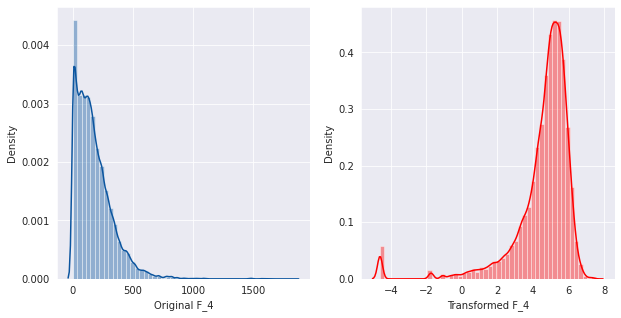


 ------------------------------------------------------

 'F_8' had 'positive' skewness of 3.59

 Transformation yielded skewness of -2.47


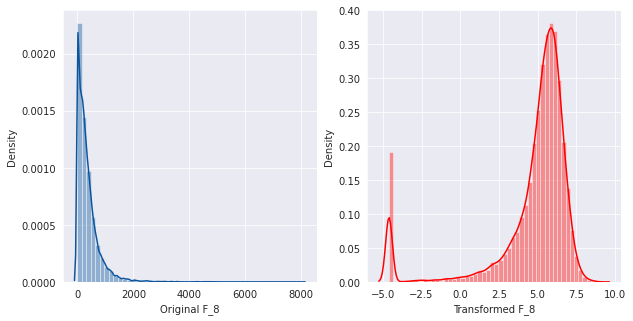


 ------------------------------------------------------

 'F_12' had 'positive' skewness of 2.52

 Transformation yielded skewness of -2.45


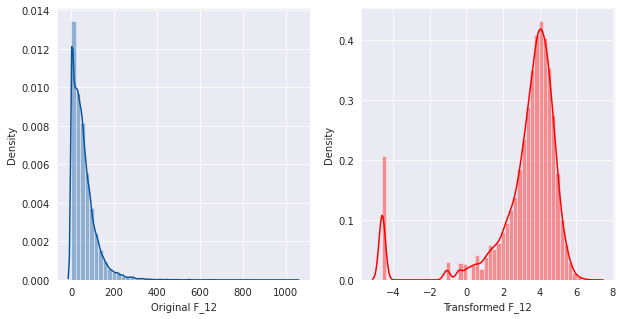


 ------------------------------------------------------

 'F_14' had 'positive' skewness of 10.87

 Transformation yielded skewness of 0.20


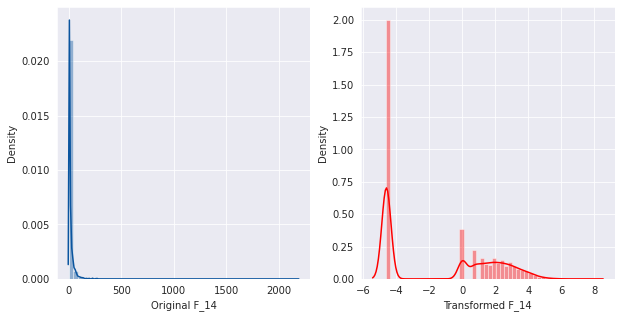


 ------------------------------------------------------

 'F_18' had 'positive' skewness of 2.02

 Transformation yielded skewness of -3.62


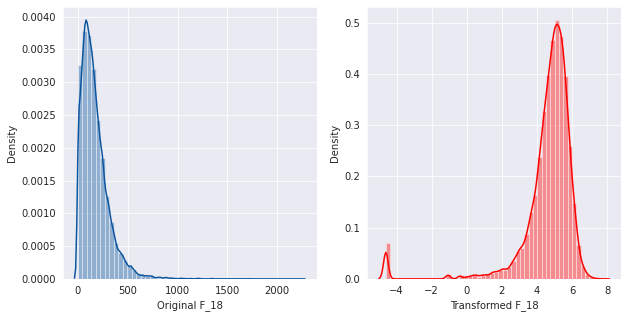


 ------------------------------------------------------

 'F_21' had 'positive' skewness of 3.79

 Transformation yielded skewness of -3.43


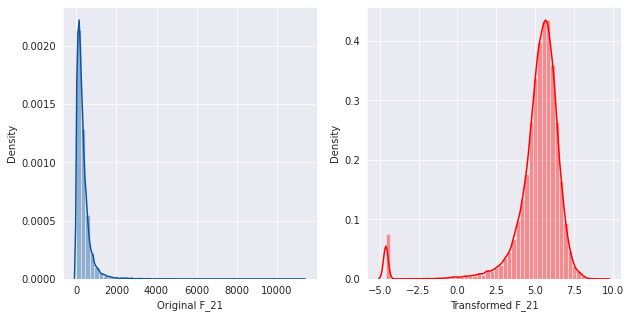


 ------------------------------------------------------

 'F_23' had 'positive' skewness of 2.94

 Transformation yielded skewness of -2.60


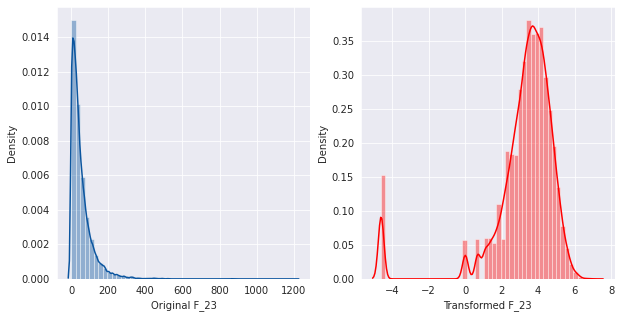


 ------------------------------------------------------

 'F_40' had 'positive' skewness of 1.03

 Transformation yielded skewness of 0.03


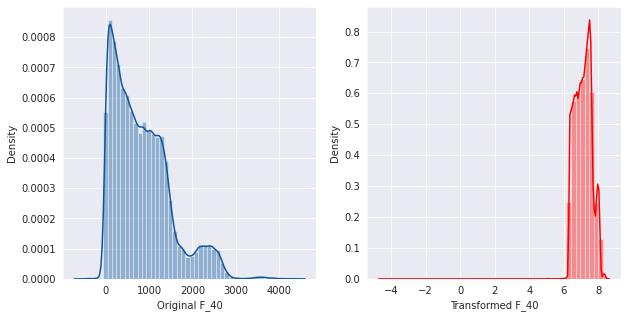


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'Label' . Skewness = 0.00


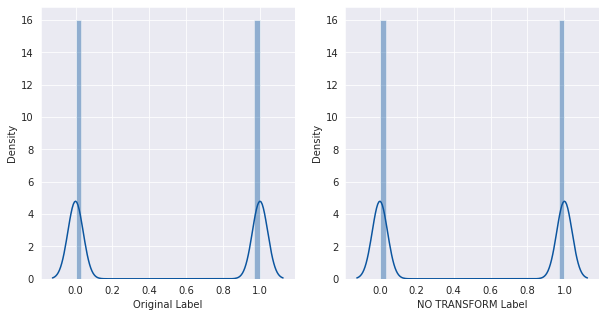

Original average skewness value was 3.17
Average skewness after transformation is 1.96


In [ ]:
transformedDF = skew_autotransform(df_upsampled.copy(deep=True), plot = True, 
                                   exp = True, threshold = 0.7, exclude = ['B','LSTAT'])

print('Original average skewness value was %2.2f' %(np.mean(abs(df_upsampled.skew()))))
print('Average skewness after transformation is %2.2f' %(np.mean(abs(transformedDF.skew()))))

In [ ]:
new = transformedDF.fillna(transformedDF.mean())

In [ ]:
new.isna().sum()

F_4      0
F_8      0
F_12     0
F_14     0
F_18     0
F_21     0
F_23     0
F_40     0
Label    0
dtype: int64

In [ ]:
new.head()

,F_4,F_8,F_12,F_14,F_18,F_21,F_23,F_40,Label
0,5.276464,5.064766,4.557484,-4.60517,4.790349,5.163795,4.248638,7.099210,0
1,6.256089,6.594108,5.015136,-4.60517,6.628936,7.008273,5.649009,8.356557,0
2,4.912728,5.129465,3.828859,-4.60517,4.581663,5.243914,4.189806,7.055321,0
3,3.314550,1.691325,0.516808,-4.60517,4.348254,3.116178,0.698135,6.927568,0
4,1.873339,1.397069,-1.069053,-4.60517,2.485740,2.150987,1.388791,6.906765,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9deeec7710>,
      dtype=object)

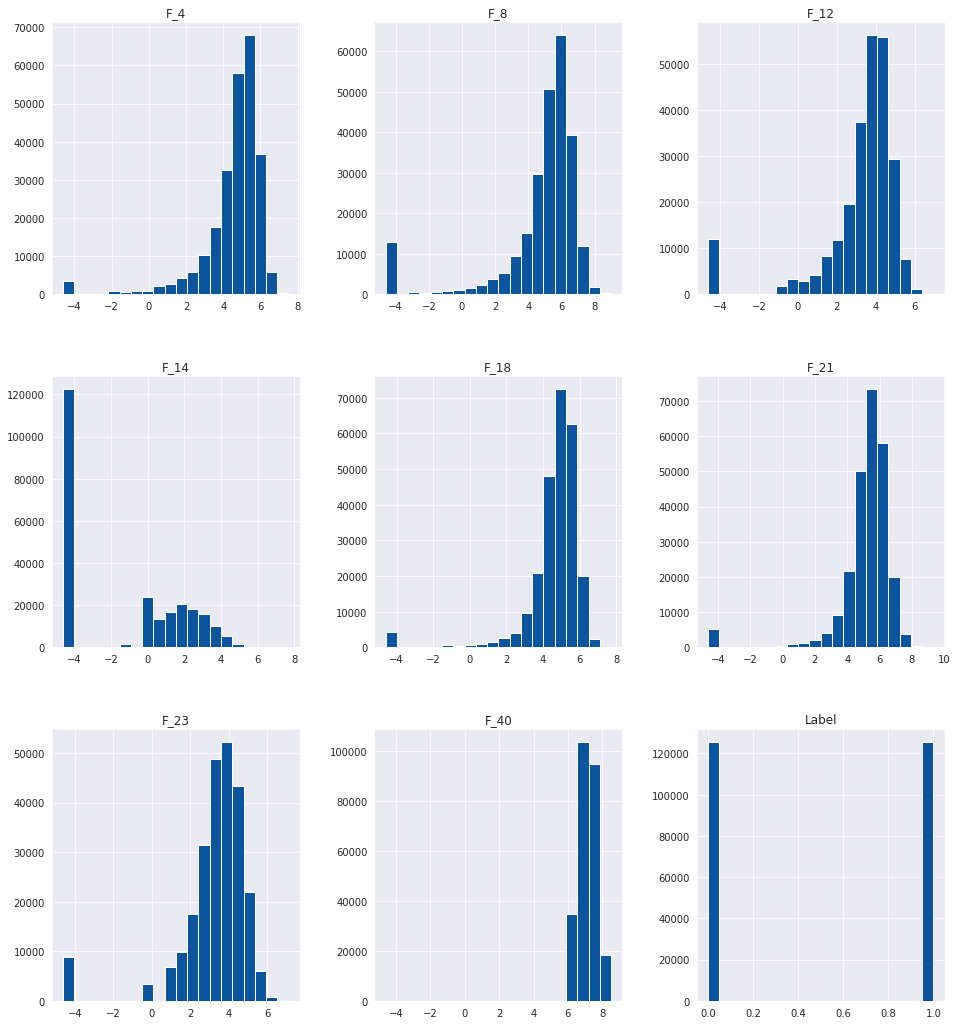

In [ ]:
new.hist(bins=20, figsize = (16,18))

In [ ]:
tr = transformedDF.drop(['F_0','F_1', 'F_35'],axis=1)

In [ ]:
tr.columns

Index(['F_4', 'F_8', 'F_12', 'F_14', 'F_18', 'F_21', 'F_23', 'F_28', 'F_36',
       'F_38', 'F_40', 'Label'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV

In [ ]:


import warnings
warnings.filterwarnings('ignore')



In [ ]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(tr.iloc[:, :-1],tr.iloc[:, -1], test_size=0.25, random_state=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tr.iloc[:, :-1],tr.iloc[:, -1],test_size=0.34)

In [ ]:
tr['Label'].value_counts()

1    89463
0    89463
Name: Label, dtype: int64

In [ ]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [ ]:


decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()



In [ ]:


# SVM = SVC(probability = True)

# scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
# scores = cross_validate(SVM, X_train, y_train, scoring=scoring, cv=20)

# sorted(scores.keys())
# SVM_fit_time = scores['fit_time'].mean()
# SVM_score_time = scores['score_time'].mean()
# SVM_accuracy = scores['test_accuracy'].mean()
# SVM_precision = scores['test_precision_macro'].mean()
# SVM_recall = scores['test_recall_macro'].mean()
# SVM_f1 = scores['test_f1_weighted'].mean()
# SVM_roc = scores['test_roc_auc'].mean()



In [ ]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [ ]:
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

In [ ]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [ ]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [ ]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [ ]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, LDA_fit_time, QDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, LDA_score_time, QDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
4,Random Forest,25.505133,0.352530,0.999001,0.999001,0.999003,0.999001,0.999924
1,Decision Tree,1.221700,0.017367,0.970658,0.972226,0.970732,0.970635,0.970702
5,K-Nearest Neighbors,0.275244,0.796303,0.930316,0.938710,0.930491,0.929988,0.974245
2,Linear Discriminant Analysis,0.238358,0.020854,0.652471,0.652628,0.652430,0.652358,0.705871
3,Quadratic Discriminant Analysis,0.078654,0.026807,0.645875,0.650741,0.645645,0.642858,0.697203
6,Bayes,0.035608,0.017461,0.643140,0.650160,0.642864,0.638744,0.692820
0,Logistic Regression,2.209965,0.020533,0.635645,0.636372,0.635551,0.635087,0.684763


In [ ]:
tr.columns

Index(['F_4', 'F_8', 'F_12', 'F_14', 'F_18', 'F_21', 'F_23', 'F_28', 'F_36',
       'F_38', 'F_40', 'Label'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new.iloc[:, :-1],new.iloc[:, -1],test_size=0.34)

In [ ]:
y_test

7865     1
30643    1
90741    1
36115    1
88802    1
        ..
43649    1
5796     1
12633    1
78894    0
68198    0
Name: Label, Length: 85387, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier()

# Fit on training data
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:

y_pred=model.predict(X_test)

In [ ]:
X_test

,F_4,F_8,F_12,F_14,F_18,F_21,F_23,F_40
7865,5.262742,7.108102,3.932022,1.793425,5.077317,6.337020,3.466048,6.894680
30643,6.066518,1.359266,3.932022,-4.605170,5.777683,5.439716,5.176206,6.946986
90741,5.646659,4.597911,4.676032,-4.605170,5.994817,5.340147,5.402722,7.544866
36115,6.176927,7.824923,4.335241,-4.605170,5.838731,7.852365,4.189806,7.208608
88802,5.234721,4.358545,3.885200,-4.605170,5.748363,6.149913,4.770769,6.986576
...,...,...,...,...,...,...,...,...
43649,5.323871,7.235782,3.989169,-4.605170,5.509429,7.745231,4.867611,6.978223
5796,5.138794,5.813613,3.555634,0.009950,4.348254,4.743133,3.332562,6.543926
12633,5.478595,6.245932,4.229410,-4.605170,5.672212,6.062218,3.555634,6.930505
78894,6.112598,5.618987,5.727965,-4.605170,6.182106,5.393143,5.129958,7.196694


In [ ]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9942262873739562


In [ ]:
test_new = test[['Unnamed: 0','F_4','F_8', 'F_12', 'F_14', 'F_18', 'F_21', 'F_23', 'F_40']]

In [ ]:
len(test_new)

55671

In [ ]:
test_new['F_4'].fillna(value=test_new['F_4'].mean(), inplace=True)
test_new['F_8'].fillna(value=test_new['F_8'].mean(), inplace=True)
test_new['F_12'].fillna(value=test_new['F_12'].mean(), inplace=True)
test_new['F_14'].fillna(value=test_new['F_14'].mean(), inplace=True)
test_new['F_18'].fillna(value=test_new['F_18'].mean(), inplace=True)
test_new['F_21'].fillna(value=test_new['F_21'].mean(), inplace=True)
test_new['F_23'].fillna(value=test_new['F_23'].mean(), inplace=True)
test_new['F_40'].fillna(value=test_new['F_40'].mean(), inplace=True)

In [ ]:
test_new.isna().sum()

Unnamed: 0    0
F_4           0
F_8           0
F_12          0
F_14          0
F_18          0
F_21          0
F_23          0
F_40          0
dtype: int64

In [ ]:
m = normalize(test_new.iloc[:, 1:])
m.head()

,F_4,F_8,F_12,F_14,F_18,F_21,F_23,F_40
0,0.000273,0.000000,0.000322,0.000000,0.000000,0.000000,0.000000,0.124110
1,0.157871,0.019346,0.191874,0.000000,0.080099,0.004601,0.038211,0.165005
2,0.103188,0.023811,0.050306,0.013356,0.092334,0.018142,0.073171,0.254527
3,0.116359,0.035412,0.083199,0.000000,0.141656,0.026338,0.082927,0.241913
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099288


In [ ]:
len(m)

55671

In [ ]:
# trDF = skew_autotransform(m.copy(deep=True), plot = True, 
#                                    exp = True, threshold = 0.7, exclude = ['B','LSTAT'])

# print('Original average skewness value was %2.2f' %(np.mean(abs(m.skew()))))
# print('Average skewness after transformation is %2.2f' %(np.mean(abs(trDF.skew()))))

In [ ]:
pred_u=model.predict(test_new.iloc[:, 1:])

In [ ]:
pred_u

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
len(trDF)

55671

In [ ]:
len(pred_u)

55671

In [ ]:
len(test)

55671

In [ ]:
out = pd.DataFrame()

In [ ]:
test.head()

,Unnamed: 0,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40
0,16380,30.0,1690.0,0.0,1.0,0.500000,1.000000,0.0,2.0,0.000000,2.0,2.0,0.0,0.333333,0.0,0.0,0.0,2.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,3.0,1900.0,0.000000,0.000000,194.800000,404.800000,0.0,2.0,2.0,179.0,179.0,122.0
1,145630,30.0,2710.0,0.0,1.0,289.666667,316.666667,388.0,543.0,218.450000,389.0,1.0,0.0,198.333333,0.0,0.0,145.0,49.0,0.0,139.666667,165.0,254.0,80.200000,0.033333,47.0,89.000000,118.0,566.0,0.0,3.0,10.0,2910.0,126.666667,233.333335,1.066618,14.483347,20.0,4.0,6.0,254.0,NaN,323.0
2,112658,30.0,1690.0,0.0,1.0,189.333333,140.666667,173.0,192.0,268.866667,173.0,0.0,0.0,52.000000,0.0,8.0,111.0,0.0,0.0,161.000000,212.0,273.0,316.233333,0.000000,90.0,81.333333,122.0,768.0,8.0,1.0,2.0,1730.0,3.333333,0.000000,120.279593,18.712925,28.0,3.0,3.0,127.0,NaN,763.0
3,102310,30.0,1603.0,0.0,1.0,213.500000,212.000000,281.0,543.0,399.866667,281.0,1.0,0.0,86.000000,0.0,0.0,185.0,1.0,0.0,247.000000,291.0,497.0,459.100000,0.000000,102.0,115.000000,189.0,2162.0,6.0,2.0,4.0,2850.0,65.833333,66.666667,-281.033344,-380.133364,17.0,5.0,6.0,233.0,NaN,701.0
4,158200,0.0,0.0,0.0,200.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.0


In [ ]:
out['ID'] = test['Unnamed: 0']

In [ ]:
out['PRED'] = pred_u

In [ ]:
out

,ID,PRED
0,16380,0
1,145630,0
2,112658,0
3,102310,0
4,158200,0
...,...,...
55666,126783,0
55667,113689,0
55668,126258,0
55669,108181,0


In [ ]:
k = out[out['PRED']==0]
l = out[out['PRED']==1]

In [ ]:
len(k)

55671

In [ ]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [ ]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = logisticRegr.predict(X_test)

In [ ]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.625844683616944


In [ ]:
logisticRegr.predict_proba(m)[:,0]

array([0.00014634, 0.00015378, 0.00017074, ..., 0.00015202, 0.00016561,
       0.00015031])

In [ ]:
pred_li = logisticRegr.predict(test_new.iloc[:, 1:])
pred_li

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
out['PRED'] = logisticRegr.predict_proba(m)[:,0]

In [ ]:
from google.colab import files
out.to_csv('out.csv', index= False) 
files.download('out.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
np.savetxt('out.csv', out, delimiter=',')

In [ ]:
clf = RandomForestClassifier(max_depth = 4, min_samples_split=2, n_estimators = 200, random_state = 1) 
clf.fit(X_train, y_train) 
predictions = clf.predict(X_test) 
predicted_probs = clf.predict_proba(m) 
print(predicted_probs) 
test = pd.concat([test, pd.DataFrame(predicted_probs, columns=['Col_0', 'Col_1'])], axis=1) 

[[0.29714014 0.70285986]
 [0.29714014 0.70285986]
 [0.29714014 0.70285986]
 ...
 [0.29714014 0.70285986]
 [0.29714014 0.70285986]
 [0.29714014 0.70285986]]


In [ ]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9942262873739562


In [ ]:
test